/var/folders/5g/_gdkfx8s4nzcbr21_35z4w2w0000gn/T/ipykernel_69274/3077591608.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Code name'] = df['Code name'].fillna("0")


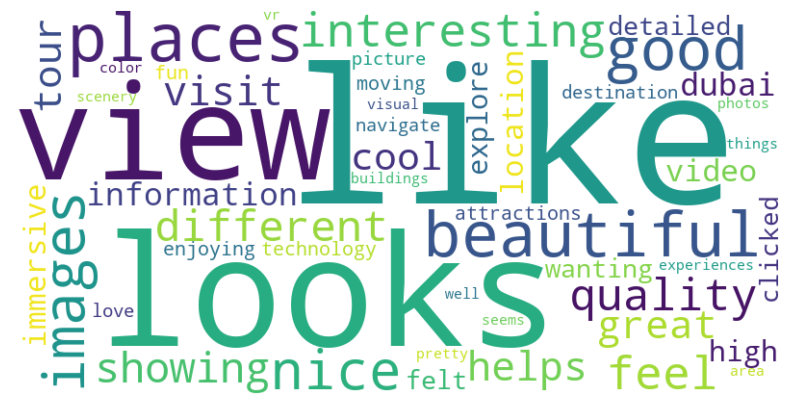

Top 10 Unique Words:
['information', 'experiences', 'destination', 'attractions', 'interesting', 'technology', 'beautiful', 'buildings', 'different', 'immersive']
-----------------------


In [1]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import csv


def removing_extra_columns(df):  
    selected_columns = ['Order', 'VR quality', 'Code name']
    df = df[selected_columns]
    df['Code name'] = df['Code name'].fillna("0")
    return df

def creating_word_cloud(df):
    df['VR quality'] = df['VR quality'].fillna("")
    comments = ' '.join(df['VR quality'])
    pattern_to_remove = r"\b\w+'\b"  # Corrected pattern to remove words with apostrophes
    all_comments = re.sub(pattern_to_remove, '', comments)
    
    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)
    stemmer = SnowballStemmer("english")

    # removing extra unnecssary words 
    stop_words.update(['easy', 'see', "way", 'use', 'clear', 'could', 'able', 'city', 'would', 'lot', 'around', 'get', 'go', 'many', 'making', 'many', "really","actually"])

    # Removing stopwords and punctuation from all_comments
    filtered_comments = ' '.join([word.lower() for word in all_comments.split() if word.lower() not in stop_words and word.lower() not in punctuations])

    words = filtered_comments.split()

    stem_to_original = {}

    stemmed_words = []
    for word in words:
        stemmed = stemmer.stem(word.lower())
        if stemmed not in stop_words and stemmed not in punctuations:
            stemmed_words.append(stemmed)
            stem_to_original[stemmed] = word.lower()

    word_counts = Counter(stemmed_words)

    # Getting the top 50 most repeated words 
    top_50_words = {stem_to_original[word]: count for word, count in word_counts.most_common(50)}

    # Generating word cloud for top 50 most repeated words 
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return top_50_words

def calculate_unique_words(top_50_words, threshold=0.1):
    word_vectors = []
    for word in top_50_words:
        vector = [1 if word == w else 0 for w in top_50_words]  # Using 1 if the words are the same, 0 otherwise
        word_vectors.append(vector)

    # Calculating cosine similarity between all pairs of words
    similarity_scores = cosine_similarity(word_vectors)

    # Initialize a set to store unique words
    unique_words = set()

    # Filtering out words that are below the threshold of similarity
    for i, word in enumerate(top_50_words):
        if all(similarity_scores[i][j] < threshold for j in range(len(top_50_words)) if j != i):
            unique_words.add(word)

    # getting top 10 most dissimliar words with longest length in words
    unique_words = sorted(unique_words, key=lambda x: len(x), reverse=True)[:10]

    return unique_words


def generate_comments_dict(all_comments, unique_words):
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', vocabulary=unique_words)
    tfidf_matrix = vectorizer.fit_transform(all_comments)
    feature_names = vectorizer.get_feature_names_out()

    # Initializing dictionary to store comments assigned to unique words
    comments_assigned_to_unique_words = {word: [] for word in unique_words}

    # Assign each comment to the most similar unique word
    for i in range(len(all_comments)):
        comment = all_comments[i]
        tfidf_vector = tfidf_matrix[i]
        most_similar_word_index = np.argmax(tfidf_vector)
        most_similar_word = feature_names[most_similar_word_index]
        comments_assigned_to_unique_words[most_similar_word].append(comment)

    # Converting dictionary to the desired format
    comments_dict = {}
    for word, comments in comments_assigned_to_unique_words.items():
        comments_dict[word] = comments

    return comments_dict

def main():
    df = pd.read_csv("data/vr_comments.csv")
    df = removing_extra_columns(df)

    top_50_words = creating_word_cloud(df)

    unique_words = calculate_unique_words(top_50_words)
    
    top_10_unique_words = list(unique_words)[:10]
    print("Top 10 Unique Words:")
    print(top_10_unique_words)
    print("-----------------------")

    
    # -------------------Creating CSV File for new labels----------------------------------
    
    # with open('data/unique_words_comments.csv', 'w', newline='') as csvfile:
    #     fieldnames = ['Unique Word', 'Comments']
    #     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #     writer.writeheader()
    #     for word, comments in comments_dict.items():
    #         for comment in comments:
    #             writer.writerow({'Unique Word': word, 'Comments': comment})
#-------------------------------------------------------------------------------------------

    # comments_dict = generate_comments_dict(df['VR quality'], unique_words)
    # for word, comments in comments_dict.items():
    #     print(f"Comments assigned to '{word}':")
    #     for comment in comments:
    #         print(comment)
    #     print()

if __name__ == "__main__":
    main()


### Making unique dictionaries

In [2]:
# import pandas as pd

# df = pd.read_csv("data/clean_vr_comments.csv")

# comments_dict = {}
# for label in df["Code name"].unique():
#     comments_for_label = df[df["Code name"] == label]["VR quality"].tolist()
#     comments_dict[label] = comments_for_label

# print("Choose a label from the following options:")
# label_options = df["Code name"].unique()
# for index, label in enumerate(label_options, start=1):
#     print(f"{index}. {label}")

# while True:
#     choice = input("Enter the name of the label: ")
#     if choice in label_options:
#         break
#     else:
#         print("Invalid label. Please enter a valid label.")

# selected_label = choice
# if selected_label in comments_dict:
#     selected_comments = comments_dict[selected_label]
#     print(f"\nTotal comments found for label '{selected_label}': {len(selected_comments)}")
#     print(f"\nComments for label '{selected_label}':")
#     for comment in selected_comments:
#         print(comment)
# else:
#     print("No comments found for the selected label.")


### Applying Sentimental Analysis 

In [3]:
# from textblob import TextBlob
# from nltk.corpus import stopwords
# import pandas as pd

# stop_words = set(stopwords.words('english'))
# df['Sentiment'] = df['VR quality'].apply(lambda x: TextBlob(x).sentiment.polarity)

# df['Sentiment Type'] = pd.cut(df['Sentiment'],
#                                 bins=[-1, -0.01, 0.01, 1],
#                                 labels=['Negative', 'Neutral', 'Positive'])

# sentiment_distribution = df['Sentiment Type'].value_counts(normalize=True) * 100

# def remove_stopwords(text):
#     return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# df['VR quality'] = df['VR quality'].apply(remove_stopwords)

# negative_neutral_comments = df[df['Sentiment Type'].isin(['Negative', 'Neutral'])]['VR quality']

# percentage_negative_neutral = (len(negative_neutral_comments) / len(df)) * 100

# sentiment_distribution


In [4]:
# positive_comments = df[df['Sentiment Type'] == 'Positive']['VR quality'].tolist()
# negative_comments = df[df['Sentiment Type'] == 'Negative']['VR quality'].tolist()
# neutral_comments = df[df['Sentiment Type'] == 'Neutral']['VR quality'].tolist()

# # Create a dictionary
# comments_dict = {
#     'Positive': positive_comments,
#     'Negative': negative_comments,
#     'Neutral': neutral_comments
# }

# comments_dict["Negative"]
